# 🏗️ Synthetic Data Generation

The first dataset generated uses 3D models of drones (object) placed into a real background image (canvas).

Number of images:
- `Training = 20264`
- `Validation = 4304`

Test data will reuse the original data set for comparison.

In [12]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from src import utils

## 1. Canvas Images

Select a set of canvas images to use for training and validation sets.

In [3]:
# Get the list of images
canvas_imgs = utils.files.get_image_files(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas"))
print(f"There are {len(canvas_imgs)} images.")

There are 77 images.


In [4]:
# Split the images into 80%/20% training/validation
trn_amount = int(0.8 * 77)

trn_canvases = np.random.choice(canvas_imgs, size=trn_amount, replace=False)

val_canvases = [canvas for canvas in canvas_imgs if canvas not in trn_canvases]

print(f"{len(trn_canvases)} training image canvases and {len(val_canvases)} validation image canvases.")

61 training image canvases and 16 validation image canvases.


In [5]:
# Save the lists for later use
trn_canvases = pd.Series(trn_canvases)
val_canvases = pd.Series(val_canvases)

trn_canvases.to_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "trn_cache.csv"), index=False)
val_canvases.to_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "val_cache.csv"), index=False)

In [2]:
# Read the lists back in
trn_canvases = pd.read_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "trn_cache.csv"))
val_canvases = pd.read_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "val_cache.csv"))

print(f"{len(trn_canvases)} training image canvases and {len(val_canvases)} validation image canvases.")

61 training image canvases and 16 validation image canvases.


## 2. Objects

Select the objects to use for the images.

In [3]:
# Get the list of 3D model files
model_paths = utils.files.get_3d_model_files(os.path.join(utils.EXTERNAL_DATA_DIR, "3d_models"))

In [4]:
# Load each of the model files into memory as a vtk object
models_list = []
for path in model_paths:
    name = os.path.splitext(os.path.basename(path))[0]
    model = utils.synth.load_3d_model(path)
    models_list.append((name, model))

Objects will be further manipulated at a later stage as they are placed onto the canvas.

## 3. Data Generation

Generate data for the training and validation sets.

### a. Training Data

In [5]:
# Set the number of training data images to create
training_total = 10  # Actual = 20264

In [6]:
# Set the data directory
train_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "3d_model_data", "train")

# Create the folders if they don't exist
os.makedirs(train_data_dir, exist_ok=True)

In [ ]:
# Set a random number generator seed for reproducibility
rng = np.random.default_rng(seed=42)

# Loop to create training data equal to the total number specified
for i in range(training_total):
    
    # Create a base file name for the final image and annotation file
    base_filename = f"3d_model_img_{i:05d}"
    
    if i % 100 == 0:
        print(f"Creating training image {i} of {training_total}")

    # Randomly select a canvas image
    canvas_path = rng.choice(trn_canvases)[0]
    canvas = Image.open(canvas_path)
    canvas_size = canvas.size

    # Select a random number of models to place in the canvas
    num_models = rng.integers(low=1, high=6)

    # Loop for each model to be placed
    for m in range(num_models):
        # Randomly select a 3D model file
        name, model = rng.choice(models_list)
        
        # Handle models with specific initial orientations
        if "shahed" in name:
            # Set initial orientation
            init_pitch = -90
            init_yaw = 0
            init_roll = -90
            
        elif "dji_m600" in name:
            # Set initial orientation
            init_pitch = 0
            init_yaw = 0
            init_roll = 0
            
        else:
            # Set initial (default) orientation
            init_pitch = 0
            init_yaw = -90
            init_roll = 0
            
        # Set a seed for the model randomization
        model_seed = (i + 1) * 10 + (m + 1)
        
        # Orient the model randomly
        model = utils.synth.camera_view(model, init_pitch=init_pitch, init_yaw=init_yaw, init_roll=init_roll, randomize=True, seed=model_seed)
        model_img = utils.synth.vtk_to_PIL(model)
        
        # Scale the object to a random size
        # Scale is a factor of the canvas size
        scale_factor = utils.synth.rng_scale(seed=model_seed)
        model_img = utils.synth.scale_obj(model_img, scale_factor, canvas_size)
        # Width and height ratios for annotation
        obj_width = model_img.size[0] / canvas_size[0]
        obj_height = model_img.size[1] / canvas_size[1]
        
        # Randomly position the object within the canvas
        coordinates_topleft = utils.synth.rng_position(model_img.size, canvas_size, seed=model_seed)
        # Calculate the center coordinates for annotation
        x_center = (coordinates_topleft[0] + model_img.size[0] / 2) / canvas_size[0]
        y_center = (coordinates_topleft[1] + model_img.size[1] / 2) / canvas_size[1]
        
        # Paste the object onto the canvas
        canvas.paste(model_img, coordinates_topleft, model_img)
        
        # Add the annotation for the object to the annotation text file
        ann = [0, x_center, y_center, obj_width, obj_height]  # Class is 0 since all objects are the same class
        with open(os.path.join(train_data_dir, f"{base_filename}.txt"), "a") as ann_file:
            ann_file.write(" ".join([str(a) for a in ann]) + "\n")
            
    # Save the final image
    canvas.save(os.path.join(train_data_dir, f"{base_filename}.png"))

Creating training image 0 of 10
data\external\canvas\kirsten-velghe-EDu8G6FZu-8-unsplash.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6000x4000 at 0x1F59986C050>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6000x4000 at 0x1F59986C050>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6000x4000 at 0x1F59986C050>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6000x4000 at 0x1F59986C050>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6000x4000 at 0x1F59986C050>
data\external\canvas\kirsten-velghe-EDu8G6FZu-8-unsplash.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6000x4000 at 0x1F59986CB00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6000x4000 at 0x1F59986CB00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6000x4000 at 0x1F59986CB00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6000x4000 at 0x1F59986CB00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6000x4000 at 0x1F59986CB00>
data\external\ca

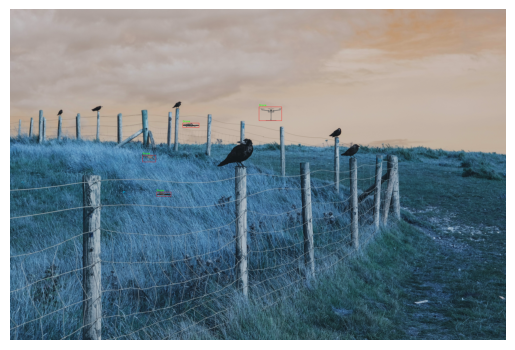

In [14]:
# Check bounding boxes
trn_imgs = utils.files.get_image_files(train_data_dir)
ann_files = utils.files.get_annotation_files(train_data_dir)

random_img = rng.integers(low=0, high=len(trn_imgs))
trn_img = trn_imgs[random_img]
ann_file = ann_files[random_img]

bboxes = utils.label_data.read_bbox_file(ann_file)

xxyy_bboxes = []
for bbox in bboxes:
    xxyy_bbox = utils.label_data.bbox_xxyy(bbox)
    xxyy_bboxes.append(xxyy_bbox)

bbox_img = utils.image_data.draw_bbox(trn_img, xxyy_bboxes)

plt.imshow(bbox_img)
plt.axis('off')
plt.show()

### b. Validation Data

In [ ]:
# Set the number of validation data images to create
validation_total = 4304

In [ ]:
# Set the data directory
val_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "3d_model_data", "val")

# Create the folders if they don't exist
os.makedirs(val_data_dir, exist_ok=True)